In [68]:
# CS 451/551
# Coding Practice Session 4
# Last name: Guthrie
# Email: mbguthrie1@crimson.ua.edu
# Q1
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler

iris = load_iris()
X = iris.data
y = iris.target
features = iris.feature_names

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

chi2_selector = SelectKBest(score_func=chi2, k='all')
chi2_selector.fit(X_scaled, y)

chi2_scores = chi2_selector.scores_

scores_df = pd.DataFrame({'Feature': features, 'Chi2_Score': chi2_scores})
scores_df = scores_df.sort_values(by='Chi2_Score', ascending=False)
scores_df

,Feature,Chi2_Score
3,petal width (cm),30.478068
2,petal length (cm),26.861936
0,sepal length (cm),11.377274
1,sepal width (cm),4.470734


In [69]:
# Q2
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X, y)
scores_df = pd.DataFrame({'Feature': features, 'Mutual_Information_Score': mi_scores})
scores_df.sort_values(by='Mutual_Information_Score', ascending=False)
scores_df

,Feature,Mutual_Information_Score
0,sepal length (cm),0.477601
1,sepal width (cm),0.265625
2,petal length (cm),0.981901
3,petal width (cm),0.982127


In [70]:
# Q3
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector
import numpy as np
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=3)

accuracies = []
feature_subsets = []

for k in range(1, X.shape[1]):
    sfs = SequentialFeatureSelector(knn, n_features_to_select=k, direction="forward", cv=5)
    sfs.fit(X, y)
    selected = np.array(features)[sfs.get_support()].tolist()
    acc = np.mean(cross_val_score(knn, sfs.transform(X), y, cv=5))
    feature_subsets.append(selected)
    accuracies.append(acc)
    print(f"{k} features: {selected} -> accuracy = {acc:.3f}")

acc_full = np.mean(cross_val_score(knn, X, y, cv=5))
print(f"4 features: {features} -> accuracy = {acc_full:.3f}")

1 features: ['petal width (cm)'] -> accuracy = 0.960
2 features: ['sepal length (cm)', 'petal width (cm)'] -> accuracy = 0.953
3 features: ['sepal length (cm)', 'petal length (cm)', 'petal width (cm)'] -> accuracy = 0.973
4 features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'] -> accuracy = 0.967


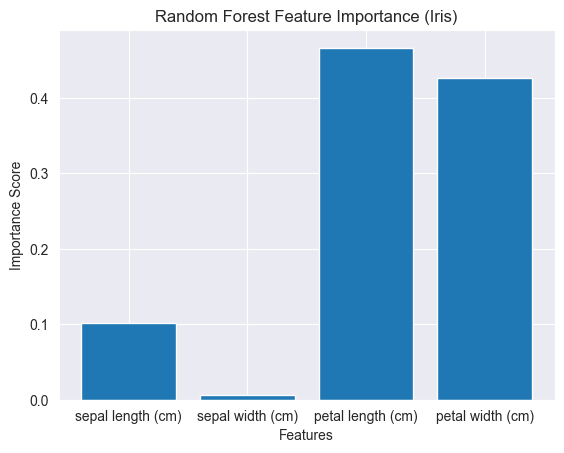

Cross-validated accuracy: 0.953
sepal length (cm): importance = 0.101
sepal width (cm): importance = 0.006
petal length (cm): importance = 0.466
petal width (cm): importance = 0.426


In [71]:
# Q4
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)

feature_importance = clf.feature_importances_

plt.bar(features, feature_importance)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.title("Random Forest Feature Importance (Iris)")
plt.show()

acc = np.mean(cross_val_score(clf, X, y, cv=5))
print("Cross-validated accuracy:", round(acc, 3))

for feat, imp in zip(features, feature_importance):
    print(f"{feat}: importance = {imp:.3f}")


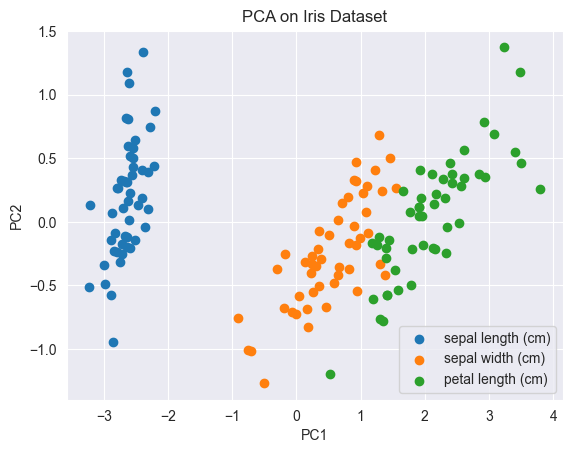

Explained variance by PC1 and PC2: [0.92461872 0.05306648]
Total variance explained by first 2 components: 0.9776852063187945


In [72]:
# Q5
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

for i, target in enumerate(set(y)):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], label=features[i])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA on Iris Dataset")
plt.legend()
plt.show()

explained_var = pca.explained_variance_ratio_
print("Explained variance by PC1 and PC2:", explained_var)
print("Total variance explained by first 2 components:", explained_var.sum())

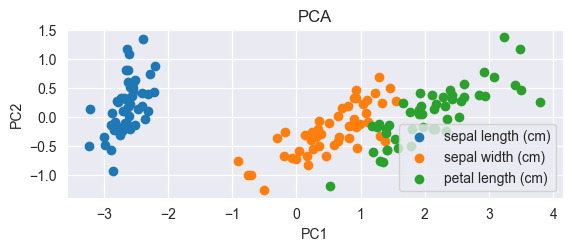

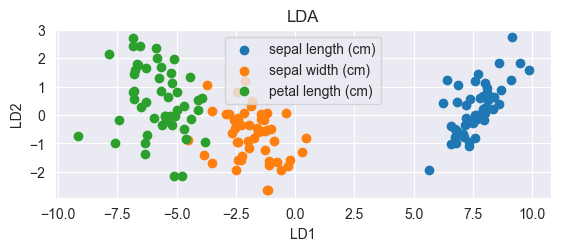

In [73]:
# Q6
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_lda = lda.fit_transform(X, y)

plt.subplot(2,1,1)
for i, target in enumerate(set(y)):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], label=features[i])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA")
plt.legend()
plt.show()


plt.subplot(2,1,2)
for i, target in enumerate(set(y)):
    plt.scatter(X_lda[y == i, 0], X_lda[y == i, 1], label=features[i])
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.title("LDA")
plt.legend()
plt.show()


sepal length (cm): importance = 0.000
sepal width (cm): importance = 0.013
petal length (cm): importance = 0.064
petal width (cm): importance = 0.923


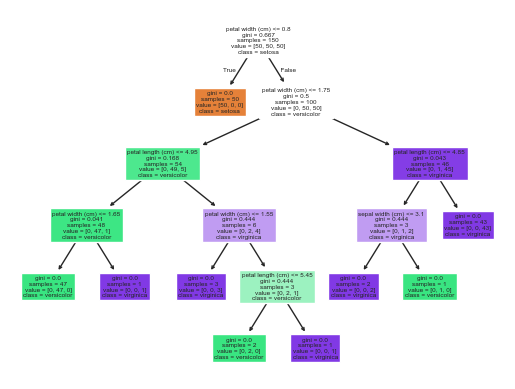

In [74]:
# Q7
from sklearn.tree import DecisionTreeClassifier, plot_tree

tree = DecisionTreeClassifier(random_state=0)
tree.fit(X, y)

for feat, imp in zip(features, tree.feature_importances_):
    print(f"{feat}: importance = {imp:.3f}")
    
plot_tree(tree, feature_names=features, class_names=iris.target_names, filled=True)
plt.show()

In [75]:
# Q8

df = pd.DataFrame(X, columns=features)
df['target'] = y

corr_with_target = df.corr()['target'].drop('target')
feature_corr = df[features].corr().abs()

cfs_scores = {}
for i, f in enumerate(features):
    relevance = abs(corr_with_target[f])
    redundancy = feature_corr[f].drop(f).mean()
    cfs_scores[f] = relevance / (redundancy + 1e-6)
    
cfs_ranked = sorted(cfs_scores.items(), key=lambda x: x[1], reverse=True)

print("Feature ranking (CFS):")
for feat, score in cfs_ranked:
    print(f"{feat}: CFS score = {score:.3f}")

Feature ranking (CFS):
sepal width (cm): CFS score = 1.403
petal width (cm): CFS score = 1.337
sepal length (cm): CFS score = 1.299
petal length (cm): CFS score = 1.258


In [76]:
# Q9
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='l1', solver='saga', max_iter=5000, C=1.0)
clf.fit(X, y)

coef = np.abs(clf.coef_).sum(axis=0)
feature_ranking = sorted(zip(features, coef), key=lambda x: x[1], reverse=True)

print("Feature ranking based on Lasso (L1) Logistic Regression:")
for feat, val in feature_ranking:
    print(f"{feat}: coefficient magnitude = {val:.3f}")

Feature ranking based on Lasso (L1) Logistic Regression:
petal length (cm): coefficient magnitude = 7.465
petal width (cm): coefficient magnitude = 4.040
sepal length (cm): coefficient magnitude = 0.847
sepal width (cm): coefficient magnitude = 0.299
